# Toxic Comment Classification

## Part2: GloVe + LSTM in Keras (in progress)
__Global Vectors (GloVe)  and Long Short Term Memory (LSTM) in Keras__

This notebook is the second part of Toxic comment classification project. The first part, Part1: Tfidf + Logistic Regression, is the other notebook in this repository. To summarize Part1, I used the Tfidf vectorization to make a feature matrix and applied logistic regressions to predict each type of toxicity separately. The AUC score was .9745 and I did some error anlaysis, which showed some possible improvement.

In Part2, I focus on neural network techniques. I will find word embeddings using a neural network layer and the found embeddings (vectors) will be fed to other layers including Long short term memory (LSTM) one. LSTM network is a recurrent neural network that captures long-term dependencies. It is known to be useful for natural language precessing (NLP) and successful at detecting patterns in long texts. This work is based on the short Kaggle kernel https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout, but I modified and extended it along with many more details.

In [5]:
# Import necessary packages
import pandas as pd
import numpy as np
#import codecs, sys, os 
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input,Embedding,Bidirectional,LSTM,GlobalMaxPool1D,Dense,Dropout,Activation
from keras.models import Model

The data sets are same as before (see Part1 for more descriptions and brief EDA)

In [6]:
# Load data sets
train = pd.read_csv('train.csv') #training set
test = pd.read_csv('test.csv') #test set

In [7]:
# comments only
train_comment_array = train['comment_text'].values
test_comment_array = test['comment_text'].values

## Word Embedding

I will use pre-trained vectors GloVe (Global vectors) downloaded from https://nlp.stanford.edu/projects/glove/ and they will be further trained using my texts in a neural network.

In [8]:
# Import pre-trained word vectors, GloVe 
word_vector_file = 'glove.6B.50d.txt'

There are several options for GloVe, but I will try to se the smallest file. 6B.50d means there are 6 billion tokens each represented as a word embedding vector of 50 dimensions.

For word embedding, I need to decide 3 numbers:
- Vocabulary size, i.e., number of words in my vocabulary: __max_feaures__
- Number of words in each comment: __maxlen__
- Dimension of a word embedding vector: __word_vec_dim__

They can be tuned to obtain better results. The value of word_vec_dim should be 50 since I use the above file.

In [9]:
word_vec_dim =50 # dimension of Glove vector

Before comments are fed to my neural networks, each comment needs to be tokenized and transformed to a sequence of numbers each representing a word. I decided to make the vocabulary of size 20000 by convention.

In [10]:
max_features = 20000 # number of words in my vocabulary

In [11]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_comment_array)+list(test_comment_array)) #input: list of texts to train on

In [12]:
tokenizer.document_count # number of documents (train + test)

312735

In [13]:
# Dictionary of word to index (index for this particular data)
word_to_index = tokenizer.word_index
print("The most frequent 10 words:",list(word_to_index.items())[:10] )
print("Number of unique words:",len(word_to_index))

The most frequent 10 words: [('the', 1), ('to', 2), ('of', 3), ('a', 4), ('and', 5), ('you', 6), ('i', 7), ('is', 8), ('that', 9), ('in', 10)]
Number of unique words: 394787


word_to_index is the dictionary of word (key): index (value) pairs. There are 394787 unique words in my data set. 

In [14]:
min(list(word_to_index.values())) # index starts from 1 (not 0)

1

Note that the index for word starts from 1, not 0.

In [15]:
word_to_count = tokenizer.word_counts
[(word, word_to_count[word]) for word,__  in list(word_to_index.items())[19990:20000]]

[('walton', 31),
 ('fragile', 31),
 ("'new", 31),
 ('spacex', 31),
 ('skimming', 31),
 ('riddle', 31),
 ('pag', 31),
 ('demonstrators', 31),
 ('gaa', 31),
 ('pogroms', 31)]

These are the least frequent 10 words and their frequencies in my vocabulary of size 20000. The frequencies are pretty negligible comparing to other frequent words, so 20000 seems to be not too small (also not too big to handle). 

In [16]:
#tokenizer.word_docs # dictionary mapping words to the number of documents that have the words

Now let's transform each comment to a sequence of word indices.

In [17]:
# List of index sequence each representing a comment
train_comment_seq = tokenizer.texts_to_sequences(train_comment_array)
test_comment_seq = tokenizer.texts_to_sequences(test_comment_array)

The number of words in each comment should be fixed as maxlen in order to be fed to a neural network. Comments longer than maxlen will be truncated and comments shorter than maxlen will be padded with zero. To decide maxlen, I will investigate the distribution of word counts in comments.

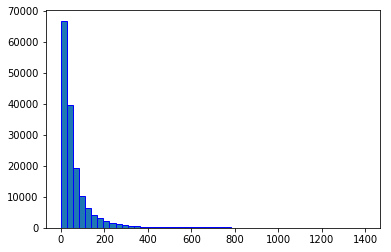

In [18]:
lengths = np.vectorize(len)
num_words = lengths(train_comment_seq)
plt.hist(num_words, bins=50, edgecolor='b')
plt.show()

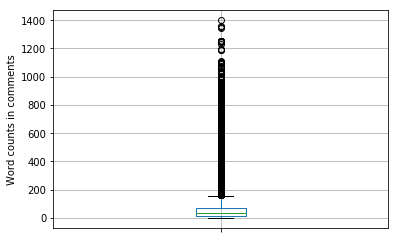

In [19]:
pd.DataFrame(num_words, columns=[' ']).boxplot()
plt.ylabel('Word counts in comments')
plt.show()

Although the number of words reaches around 1400, the outliers start before 200 words and the box does not reach even 100 words. Thus, I tried both 200 and 100 for maxlen and 200 maxlen did not improve the performance much while 200 takes much longer than 100 maxlen. Therefore, I decided to use 100 for my final report, but again the number can be further tuned for better results.

In [20]:
maxlen = 100 # fixed number of words in each comment

In [21]:
# Truncate and pad (with zeros) to make equal size comments
train_comment_seq_pad = pad_sequences(train_comment_seq, maxlen = maxlen, padding='post', truncating='post' )
test_comment_seq_pad = pad_sequences(test_comment_seq, maxlen = maxlen, padding='post', truncating='post' )

Actually, padding='pre', truncating='pre' are default values. I tried the combination of padding='pre', truncating='post' (with maxlen = 200), but they gave pretty similar results.

Now it is time to make the embedding matrix. The GloVe txt file has data like this 'the 0.418 0.24968 -0.41242 0.1217 ...' for the token 'the'. To separate the first item, the word 'the', from the rest, a sequence of numbers representing the word vector for 'the', I need a helper function get_word_vec.

In [22]:
def get_word_vec(word,*vec): 
    return word, np.asarray(vec, dtype='float32')

In [23]:
# Make a dictionary mapping a word to its GloVe vector (encoding="utf8" removed the error) 
word_to_vec = dict(get_word_vec(*item.strip().split()) for item in open(word_vector_file, encoding="utf8"))

I will initialize an embedding matrix as a numpy array of shape (max_features, word_vec_dim) with random numbers from a normal distribution. The normal distribution has mean and standard deviation of word_to_vec values aggregated across all vectors. By this way of initialization, new words not among the pretrained words can have word vectors similar to those of pretrained words before being trained here. I assumed max_feaures is less than or equal to the number of unique words in texts since max_feaures = 20000 and len(word_to_index) = 394787 in my data set. The words in the embedding matrix will be ordered as in the words in word_to_index.

In [24]:
# check mean and std of aggregated values of word_to_vec
np.stack(word_to_vec.values()).mean(), np.stack(word_to_vec.values()).std()

(0.020940498, 0.6441043)

In [25]:
# Make embedding matrix
embed_matrix = np.random.normal(np.stack(word_to_vec.values()).mean(), 
                                np.stack(word_to_vec.values()).std(),
                               (max_features, word_vec_dim))

for word, idx in word_to_index.items():
    if idx > max_features: # index idx starts from 1 (not 0) in word_to_index
        break
    vec = word_to_vec.get(word, None) # need get() to get None for the case word is not in keys
    if vec is not None:
        embed_matrix[idx-1] = vec

## LSTM

In [105]:
categories =['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [108]:
# Labels of training set
labels = train[categories].values
labels

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]], dtype=int64)

### Model1

In [111]:
# Model with Bidirectional LSTM(50)+dropout(0.1) + GlobalMaxPool1D + Dense(50 & 6)

# Define comment_sequences as input of the model
comment_sequences = Input(shape=(maxlen,))
# Propagate comment_sequences through embedding layer and output the embeddings
X = Embedding(max_features, word_vec_dim, weights=[embed_matrix])(comment_sequences)
# Propagate the embeddings through Bi-LSTM layer with 50 dimensional hidden state
# Add dropouts for both directions (rate can be tuned)
X = Bidirectional(LSTM(50, return_sequences= True, dropout= 0.1, recurrent_dropout= 0.1))(X)
# Apply Global max pooling for temporal data of 3D tensor and output 2D tensor without temporal dim
X = GlobalMaxPool1D()(X)
# Propagate X through a Dense layer to output a batch of 50 dim vectors
X = Dense(50, activation= "relu")(X) 
# Add dropouts
X = Dropout(0.1)(X) 
# Propagate X through a Dense layer to output a batch of 6 dim vectors ( 1 dim for each category)
# Add sigmoid activation to get probability between 0 and 1 for each cateogry
X = Dense(6, activation= "sigmoid")(X)
# Create Model which converts input comment_sequences into output X
model = Model(inputs= comment_sequences, outputs= X)
# Compile the model with binary crossentropy loss function and adaptive momentum optimizer
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

There are many tunable hyperparameters like dropout rates, activation functions, dimensions of LSTM and  dense layer, optimizers. Although we need AUC, we cannot choose AUC for metrics since AUC cannot be accumulated in mini batches. If necessary, AUC has to be computed using all data.

In [113]:
%%time
model.fit(train_comment_seq_pad, labels, batch_size=32, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 328s 2ms/step - loss: 0.0635 - acc: 0.9783 - val_loss: 0.0502 - val_acc: 0.9820
Epoch 2/2
143613/143613 [==============================] - 327s 2ms/step - loss: 0.0459 - acc: 0.9830 - val_loss: 0.0502 - val_acc: 0.9817
Wall time: 10min 55s


In [117]:
# Make predictions for test set
prob_predictions = model.predict([test_comment_seq_pad], batch_size=1024, verbose=1)

153164/153164 [==============================] - 39s 257us/step


In [136]:
# submission
submission = pd.read_csv('sample_submission.csv')
submission[categories]= prob_predictions #can enter multiple columns at once if columns are already there
submission.to_csv('submission_LSTM1.csv', index=False)

The only way to check performance on the test set is submitting my predictions to the leader board (LB) on Kaggle, so I prepared the submisison file and submitted.

LB AUC: 0.9704 

This is slighly worse than Tfidf + Logistic regression model (.9745) in Part1.

### Model2

Here I check if not training the pretrained embedding vectors (trainable= False) improves the performance.

In [148]:
%%time
# same as model1 except for trainable = False
comment_sequences = Input(shape=(maxlen,))
X = Embedding(max_features, word_vec_dim, weights=[embed_matrix], trainable= False)(comment_sequences)
X = Bidirectional(LSTM(50, return_sequences= True, dropout= 0.1, recurrent_dropout= 0.1))(X)
X = GlobalMaxPool1D()(X)
X = Dense(50, activation= "relu")(X)
X = Dropout(0.1)(X)
X = Dense(6, activation= "sigmoid")(X)
model = Model(inputs= comment_sequences, outputs= X)
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

model.fit(train_comment_seq_pad, labels, batch_size=32, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 244s 2ms/step - loss: 0.1043 - acc: 0.9692 - val_loss: 0.0895 - val_acc: 0.9727
Epoch 2/2
143613/143613 [==============================] - 240s 2ms/step - loss: 0.0779 - acc: 0.9755 - val_loss: 0.0732 - val_acc: 0.9763
Wall time: 8min 7s


In [149]:
# Make predictions for test set
prob_predictions = model.predict([test_comment_seq_pad], batch_size=1024, verbose=1)

# submission
submission = pd.read_csv('sample_submission.csv')
submission[categories]= prob_predictions #can enter multiple columns at once if columns are already there
submission.to_csv('submission_LSTM4.csv', index=False)

153164/153164 [==============================] - 50s 328us/step


LB AUC: 0.9211 (

This is much worse than the trainable embedding layer (Model1)!

### Model3 

Here I try a different architecture that I used for another NLP project where I predicted emotion from senetences. The key differences in this model: 

- LSTM instead of Bidirectional LSTM
- LSTM has the higher dimension (128) for hidden state 
- Higher dropout rates (.5)
- Repeat the above steps twice
- Only one necessary Dense layer with dimension 6

In [145]:
%%time
# not bidirectional LSTM(128)+dropout(0.5) twice 
comment_sequences = Input(shape=(maxlen,))
X = Embedding(max_features, word_vec_dim, weights=[embed_matrix])(comment_sequences)
X = LSTM(128, return_sequences= True)(X)
X = Dropout(rate=.5)(X)
X = LSTM(128, return_sequences = False)(X)
X = Dropout(rate=.5)(X)
X = Dense(6, activation= "sigmoid")(X)

model = Model(inputs= comment_sequences, outputs= X)
model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])

model.fit(train_comment_seq_pad, labels, batch_size=32, epochs=2, validation_split=0.1)

Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 521s 4ms/step - loss: 0.1004 - acc: 0.9709 - val_loss: 0.0567 - val_acc: 0.9804
Epoch 2/2
143613/143613 [==============================] - 526s 4ms/step - loss: 0.0529 - acc: 0.9815 - val_loss: 0.0525 - val_acc: 0.9810
Wall time: 17min 29s


In [146]:
# Make predictions for test set
prob_predictions = model.predict([test_comment_seq_pad], batch_size=1024, verbose=1)

# submission
submission = pd.read_csv('sample_submission.csv')
submission[categories]= prob_predictions #can enter multiple columns at once if columns are already there
submission.to_csv('submission_LSTM3.csv', index=False)

153164/153164 [==============================] - 95s 619us/step


LB AUC: 0.9564 

Unfortunately, this model is worse than model1. However, again there are many tunable hyperparameters that can improve this architecture.

## Simple Ensemble: Logistic Regression with Tfidf & LSTM with GloVe

I will try a very simple ensemble model.

In [153]:
pred_LR = pd.read_csv('submission.csv') #AUC=.9745 (from Part1 notebook)
pred_LSTM = pd.read_csv('submission_LSTM1.csv') #AUC=.9704 (model1 in this notebook)

In [151]:
pred_Emsemble = (pred_LR[categories].values + pred_LR[categories].values)/2

submission = pd.read_csv('sample_submission.csv')
submission[categories]= pred_Emsemble #can enter multiple columns at once if columns are already there
submission.to_csv('submission_LR_LSTM.csv', index=False)

LB AUC: 0.9744 (not better than Logistic Regression with Tfidf only) 

It is possible that the two model predictions are high correlated and that's why this ensemble does not perform better than the logistic regression model. Let me check the correlations for each category.

In [161]:
# check correlation between the two model predictions
print('Correlation between two model predictions:') 
correl = []
for category in categories:
    corr = np.corrcoef(pred_LR[category], pred_LSTM[category])[0,1]
    correl.append(corr)
    print(category)
    print("%0.4f"%corr)

Correlation between two model predictions:
toxic
0.9149
severe_toxic
0.7793
obscene
0.9185
threat
0.2988
insult
0.8697
identity_hate
0.6699


The correlation coefficients between two model predictions are pretty high except for threat (less than .3). In particular, the correlations for each of toxic, obsecene, and insult are very high (over .85). This remids me of that I tuned the hyperparameters for the logistic regression model for each category. There I found less regularization is required for more unbalanced categories. The above correlations seem to correlated with the level of imbalances. 

In [165]:
# proportions of toxic comments for each category
positive_rate = labels.mean(axis=0)
positive_rate

array([0.09584448, 0.00999555, 0.05294822, 0.00299553, 0.04936361,
       0.00880486])

In [172]:
# rank order correlation between two model correlations and proportions of toxic comments
import scipy.stats as stats
stats.spearmanr(correl, positive_rate)

SpearmanrResult(correlation=0.942857142857143, pvalue=0.004804664723032055)

This high correlation could be from poor performances of LSTM for some categories. Thus, I will now check performances of the LSTM model separately for each category. Then, I will apply different levels of regularization or even different architectures for different categories to improve the overall performance.

First, I will fit the model for each category to see if this improves the performance.

In [197]:
submission = pd.read_csv('sample_submission.csv')

for category in categories:
    comment_sequences = Input(shape=(maxlen,))
    X = Embedding(max_features, word_vec_dim, weights=[embed_matrix])(comment_sequences)
    X = Bidirectional(LSTM(50, return_sequences= True, dropout= 0.1, recurrent_dropout= 0.1))(X)
    X = GlobalMaxPool1D()(X)
    X = Dense(50, activation= "relu")(X)
    X = Dropout(0.1)(X)
    X = Dense(1, activation= "sigmoid")(X)
    model = Model(inputs= comment_sequences, outputs= X)
    model.compile(loss= 'binary_crossentropy', optimizer= 'adam', metrics= ['accuracy'])  
    print("### Fitting for {} ###".format(category))
    model.fit(train_comment_seq_pad, train[category], batch_size=32, epochs=2, validation_split=0.1)
    submission[category] = model.predict([test_comment_seq_pad], batch_size=1024, verbose=1)
    
submission.to_csv('submission_LSTM5.csv', index=False)

### Fitting for toxic ###
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 342s 2ms/step - loss: 0.1509 - acc: 0.9480 - val_loss: 0.1057 - val_acc: 0.9615
Epoch 2/2
153164/153164 [==============================] - 54s 351us/step
### Fitting for severe_toxic ###
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 341s 2ms/step - loss: 0.0318 - acc: 0.9900 - val_loss: 0.0217 - val_acc: 0.9910
Epoch 2/2
153164/153164 [==============================] - 54s 354us/step
### Fitting for obscene ###
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==============================] - 344s 2ms/step - loss: 0.0873 - acc: 0.9727 - val_loss: 0.0628 - val_acc: 0.9796
Epoch 2/2
153164/153164 [==============================] - 57s 372us/step
### Fitting for threat ###
Train on 143613 samples, validate on 15958 samples
Epoch 1/2
143613/143613 [==================

LB AUC: .9755

This is better than all of the previous models I tried including LSTM model1 above and logistic regression model in Part1.

In [182]:
# check if auc for the last category identity hate is also that high
from sklearn import metrics
pred = model.predict([train_comment_seq_pad], batch_size=1024, verbose=1) #for identity hate
y = train['identity_hate']
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
metrics.auc(fpr, tpr)
# Yes, AUC is very high just like accuracy for identity hate

0.9938879274682488

It seems the Glove+LSMT model is especially better than Tfidf+LR model for more severely unbalanced categories (accuracy > .99). Thus, I will use the predictions by Tfidf+LR for toxic, obscene, and insult categories and predictions by GloVe+LSMT for severe toxic, threat, and identity hate categories and see if this combined prediction improves AUC. 

In [198]:
pred_LR = pd.read_csv('submission.csv') #AUC=.9745 (from Part1 notebook)
pred_LSTM = pd.read_csv('submission_LSTM5.csv') #AUC=.9755 

submission = pd.read_csv('sample_submission.csv')

submission['toxic']= pred_LR['toxic']
submission['severe_toxic']= pred_LSTM['severe_toxic']
submission['obscene']= pred_LR['obscene']
submission['threat']= pred_LSTM['threat']
submission['insult']= pred_LR['insult']
submission['identity_hate']= pred_LSTM['identity_hate']

submission.to_csv('submission_LR_LSTM_3.csv', index=False)

LB AUC: 0.9751 (not better than LSTM only)

I will try the simple ensemble model I tried above since the LSTM model was improved by fitting each category.

In [200]:
pred_Emsemble = (pred_LR[categories].values + pred_LR[categories].values)/2

submission = pd.read_csv('sample_submission.csv')
submission[categories]= pred_Emsemble #can enter multiple columns at once if columns are already there
submission.to_csv('submission_LR_LSTM_5.csv', index=False)

LB AUC: 0.9744 (not better than LSTM only)

The categories severe toxic, threat, and identity hate are also those with lower correlations between the two models, so the simple ensemble model might work only for those categories.

In [199]:
submission = pd.read_csv('sample_submission.csv')

submission['toxic']= pred_LR['toxic']
submission['severe_toxic']= (pred_LR['severe_toxic']+pred_LSTM['severe_toxic'])/2
submission['obscene']= pred_LR['obscene']
submission['threat']= (pred_LR['threat']+pred_LSTM['threat'])/2
submission['insult']= pred_LR['insult']
submission['identity_hate']= (pred_LR['identity_hate']+pred_LSTM['identity_hate'])/2

submission.to_csv('submission_LR_LSTM_4.csv', index=False)

LB AUC: 0.9770 

Yes! This is the best AUC I've ever got.

## Summary so far

- Made predictions using GloVe word embedding + LSTM in Keras. 
- Used multi-task learning for multiple lables (1 by 6 vector label) as mentioned in the future directions of Part1
- LSTM models with multi-task learning was worse than the Tfidf + Logistic regression model
- Fitting each category for the LSTM model was much slower, but made better predictions than the logistic regression
- Found a simple ensemble method (the last one) can increase AUC even further